In [8]:
from BZ import *

import xarray as xr

%pdb off
%matplotlib inline

# print ('\nData is at:', os.getenv('dataroot'))
print (os.getenv('CONDA_PROMPT_MODIFIER'), datetime.now().date())

Automatic pdb calling has been turned OFF
(MintPy)  2023-03-29


In [31]:
## Helpers
class wmRaid(object):
    def __init__(self, date='20180811', time='220000'):
        self.path_root = '/u/leffe-data2/buzzanga/data/VLM/Sentinel1/NYC_ARIA/raider_files'
        self.date = date
        self.time = time
        self.dt   = pd.to_datetime(f'{date}{time}')
        self.dt_s = self.dt.strftime('%Y_%m_%d_T%H_%M_%S')



    def load_wm_0(self, wm):
        """ Load the first stage of raider weather file """
        path_wm   = op.join(self.path_root, f'weather_files_{wm}')
        wm  = 'ERA-5' if wm == 'ERA5' else wm

        src = op.join(path_wm, f'{wm}_{self.dt_s}.nc')
        ds  = xr.open_dataset(src)
        return ds


    def load_wm_1(self, wm, S=40, N=43, W=76, E=72):
        """ Load the second stage of raider weather file """
        path_wm   = op.join(self.path_root, f'weather_files_{wm}')
        wm  = 'ERA-5' if wm == 'ERA5' else wm
        src = op.join(path_wm, f'{wm}_{self.dt_s}_{S}N_{N}N_{W}W_{E}W.nc')
        ds  = xr.open_dataset(src)

        return ds
    
    def load_grib(self, wm, S=30, N=50, W=80, E=70):
        """ Get the grib files from mintpy """
        dt = self.dt.strftime('%Y%m%d_%H')
        path_wm   = op.join(op.dirname(self.path_root), 'ERA5_PRODS')

        src = op.join(path_wm,f'{wm}_N{S}_N{N}_W{W}_W{E}_{dt}.grb')
        ds  = xr.open_dataset(src, engine='cfgrib')
        return ds
        

from pyproj import CRS, Transformer
p1 = CRS(f'+proj=lcc +lat_1=38.5 +lat_2=38.5 +lat_0=38.5 '\
         f'+lon_0=262.5 +x_0=0 +y_0=0 +a=6371229 '\
         f'+b=6371229 +units=m +no_defs')

T = Transformer.from_crs('epsg:4326', p1, always_xy=True)
# lat, lon = 42.077, -72.71423
lat, lon = 40.725, -73.8
x, y = T.transform(lon, lat)

## Compare the raw weather files

In [90]:
Obj     = wmRaid()
# ds_hres = Obj.load_wm_0('HRES')
ds_era5 = Obj.load_wm_0('ERA5').rename(latitude='lat', longitude='lon')
ds_hrrr = Obj.load_wm_0('HRRR')


In [91]:
# random point
da_era5 = ds_era5.sel(lat=lat, lon=lon)
da_hrrr = ds_hrrr.sel(x=x, y=y, method='nearest')

In [99]:
da_era5

<xarray.Dataset>
Dimensions:  (level: 37, time: 1)
Coordinates:
    lon      float32 -72.71
    lat      float32 42.08
  * level    (level) int32 1 2 3 5 7 10 20 30 ... 850 875 900 925 950 975 1000
  * time     (time) datetime64[ns] 2018-08-11T22:00:00
Data variables:
    z        (time, level) float32 ...
    q        (time, level) float32 ...
    t        (time, level) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-03-28 03:50:50 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

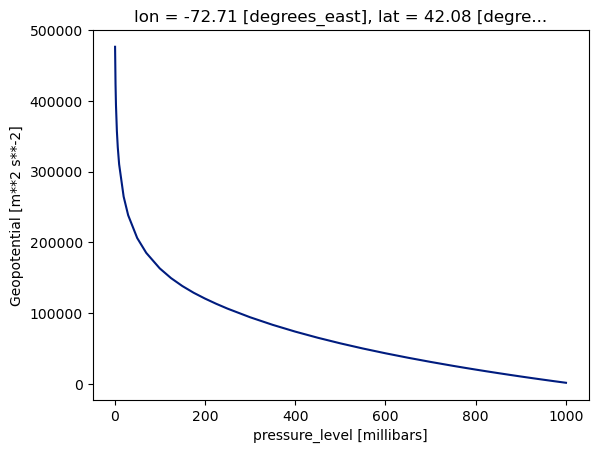

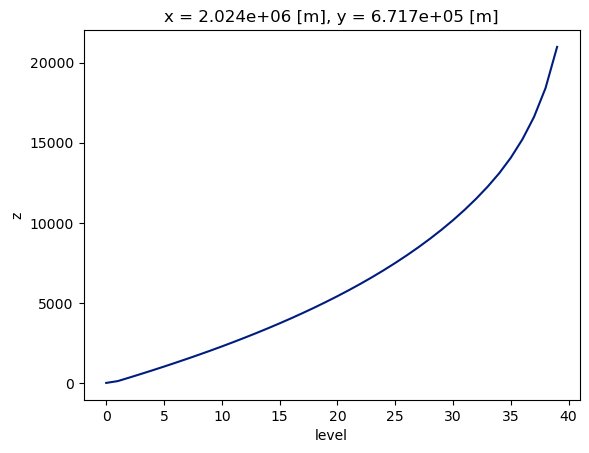

In [105]:
v = 'z'
fig, axes = plt.subplots(figsize=(8,8), ncols=2, sharey=True)
da_era5[v].plot(ax=axes, title='ERA5')
da_hrrr[v].plot(ax=axes, title='HRRR')

#### Compare ERA5 RAiDER vs MintPy

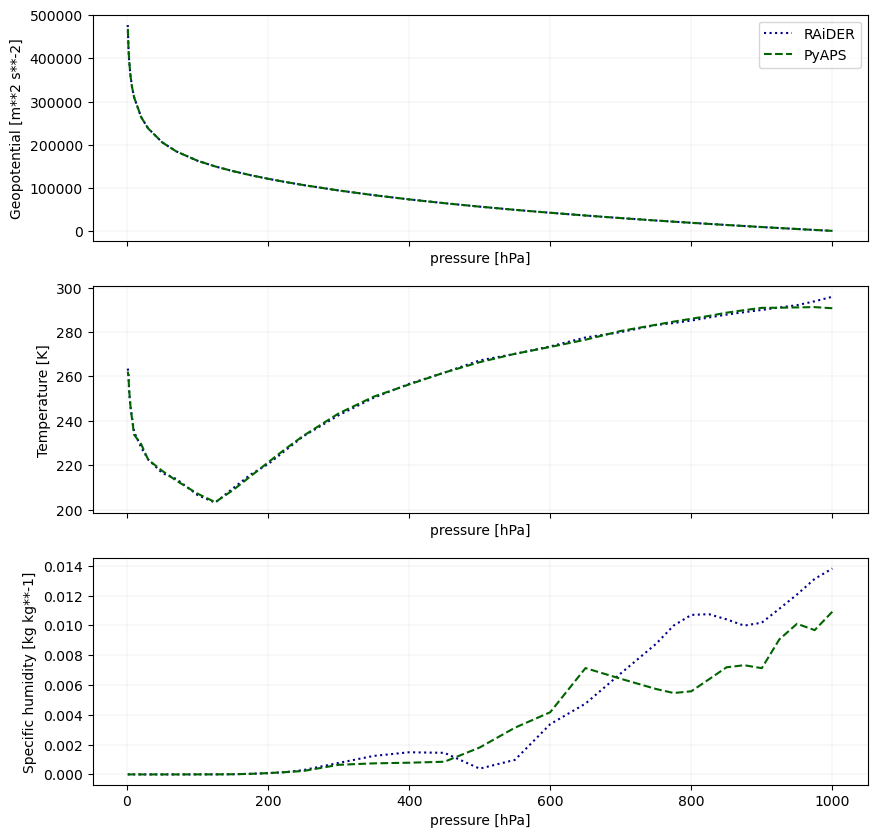

In [32]:
## check the next stage of the models
date = '20170723' # '20180811'
Obj     = wmRaid(date=date, time='230000')
ds_era5 = Obj.load_wm_0('ERA5')
ds_era5_pyaps = Obj.load_grib('ERA5')

da_era5 = ds_era5.sel(longitude=lon, latitude=lat, method='nearest')
da_era5_pyaps = ds_era5_pyaps.sel(latitude=lat, longitude=y, method='nearest')

fig, axes = plt.subplots(nrows=3, figsize=(10,10), sharex=True)


v     = 'z'
da_era5[v].plot(ax=axes[0], color='darkblue', linestyle=':', label='RAiDER')
da_era5_pyaps[v].plot(ax=axes[0], color='darkgreen', linestyle='--', label='PyAPS')
# lines[0].axes.set_ylim([0, 80000])
# lines[0].axes.set_xlim([0, 80000])

v     = 't'
da_era5[v].plot(ax=axes[1], color='darkblue', linestyle=':', label='RAiDER')
da_era5_pyaps[v].plot(ax=axes[1], color='darkgreen', linestyle='--', label='PyAPS')

v     = 'q'
da_era5[v].plot(ax=axes[2], color='darkblue', linestyle=':', label='RAiDER')
da_era5_pyaps[v].plot(ax=axes[2], color='darkgreen', linestyle='--', label='PyAPS')


axes[0].legend()
for ax in axes:
    ax.set_title('')
    ax.grid(color='gray', linestyle = '--', linewidth=0.1)

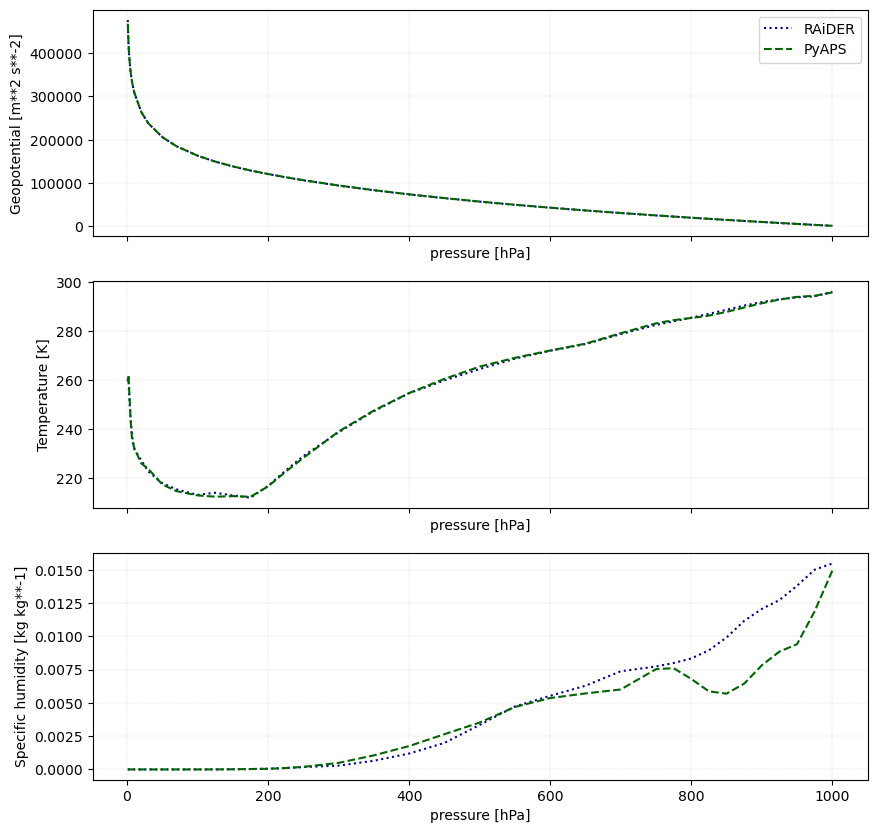

In [33]:
Obj     = wmRaid(time='230000')
# ds_hres = Obj.load_wm_0('HRES')
ds_era5 = Obj.load_wm_0('ERA5')
ds_era5_pyaps = Obj.load_grib('ERA5')

da_era5 = ds_era5.sel(longitude=lon, latitude=lat, method='nearest')
da_era5_pyaps = ds_era5_pyaps.sel(latitude=lat, longitude=y, method='nearest')

fig, axes = plt.subplots(nrows=3, figsize=(10,10), sharex=True)


v     = 'z'
da_era5[v].plot(ax=axes[0], color='darkblue', linestyle=':', label='RAiDER')
da_era5_pyaps[v].plot(ax=axes[0], color='darkgreen', linestyle='--', label='PyAPS')
# lines[0].axes.set_ylim([0, 80000])
# lines[0].axes.set_xlim([0, 80000])

v     = 't'
da_era5[v].plot(ax=axes[1], color='darkblue', linestyle=':', label='RAiDER')
da_era5_pyaps[v].plot(ax=axes[1], color='darkgreen', linestyle='--', label='PyAPS')

v     = 'q'
da_era5[v].plot(ax=axes[2], color='darkblue', linestyle=':', label='RAiDER')
da_era5_pyaps[v].plot(ax=axes[2], color='darkgreen', linestyle='--', label='PyAPS')


axes[0].legend()
for ax in axes:
    ax.set_title('')
    ax.grid(color='gray', linestyle = '--', linewidth=0.1)

## Compare the cropped weather files

In [123]:
## check the next stage of the models
Obj     = wmRaid()
# ds_hres = Obj.load_wm_0('HRES')
ds_era5 = Obj.load_wm_1('ERA5')
ds_hrrr = Obj.load_wm_1('HRRR', 41, 43, 76, 72)

da_era5 = ds_era5.sel(x=lon, y=lat, method='nearest')
da_hrrr = ds_hrrr.sel(x=x, y=y, method='nearest')

In [141]:
da_era5

<xarray.Dataset>
Dimensions:      (z: 32)
Coordinates:
    x            float64 -72.71
    y            float64 42.08
  * z            (z) float32 -500.0 -300.0 -200.0 ... 4.374e+04 4.841e+04
Data variables:
    WGS84        |S1 ...
    latitude     (z) float64 ...
    longitude    (z) float64 ...
    t            (z) float32 ...
    p            (z) float32 ...
    e            (z) float32 ...
    wet          (z) float32 ...
    hydro        (z) float32 ...
    wet_total    (z) float32 ...
    hydro_total  (z) float32 ...
Attributes:
    Conventions:   CF-1.6
    datetime:      2018_08_11T22_00_00
    date_created:  2023_03_27T20_53_07
    title:         Weather model data and delay calculations

(0.0, 80000.0)

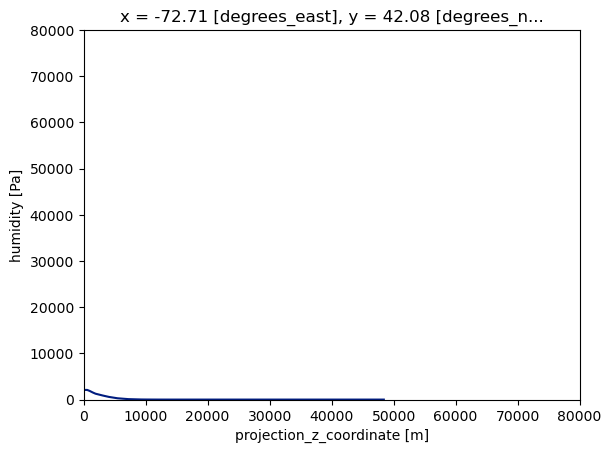

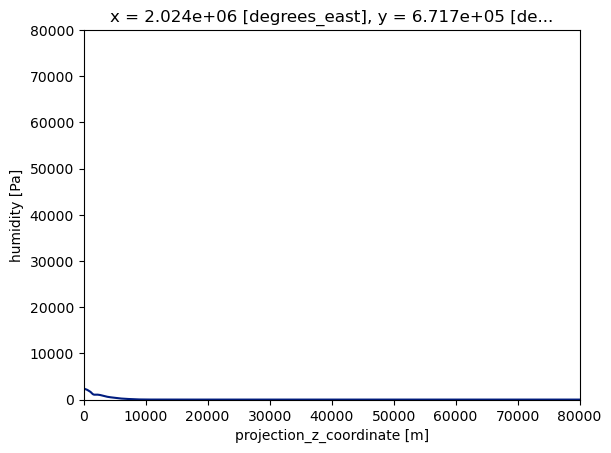

In [142]:
v     = 'p'
lines = da_era5[v].plot()
lines[0].axes.set_ylim([0, 80000])
lines[0].axes.set_xlim([0, 80000])

plt.figure()
lines = da_hrrr[v].plot()
lines[0].axes.set_ylim([0, 80000])
lines[0].axes.set_xlim([0, 80000])


# print (da_era5)



(0.0, 80000.0)

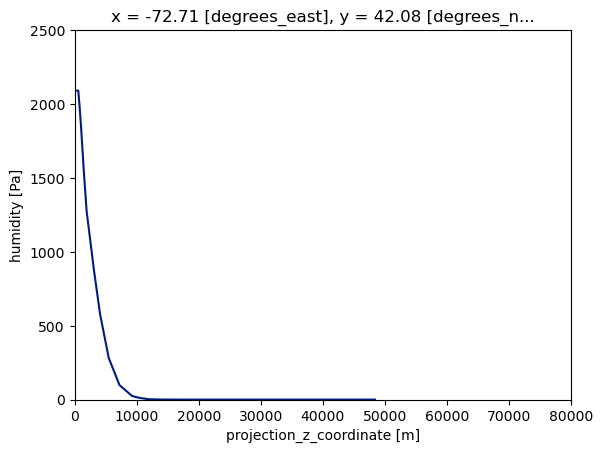

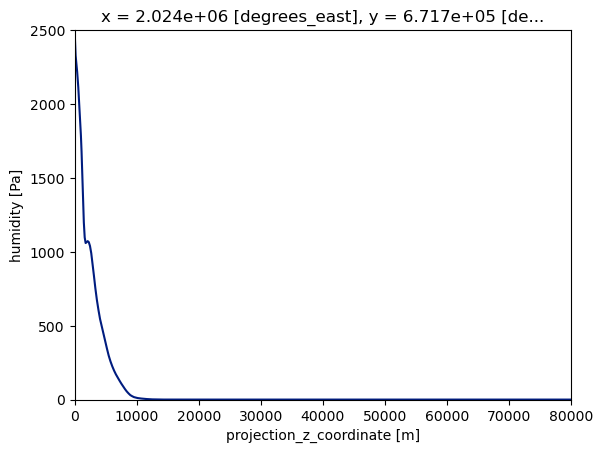

(0.0, 80000.0)

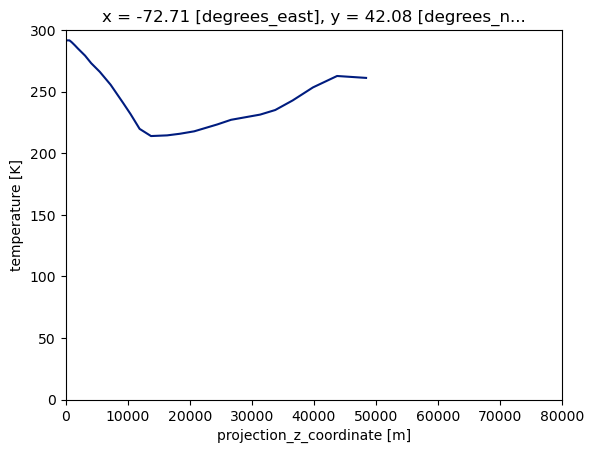

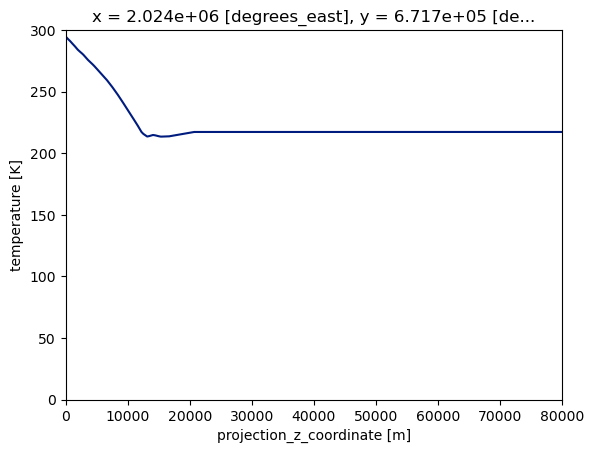

In [147]:
v     = 't'
lines = da_era5[v].plot()
lines[0].axes.set_ylim([0, 300])
lines[0].axes.set_xlim([0, 80000])

plt.figure()
lines = da_hrrr[v].plot()
lines[0].axes.set_ylim([0, 300])
lines[0].axes.set_xlim([0, 80000])


# print (da_era5)